# Recreating a published edge detection based image segmentation algorithm
[A Novel Edge Detection Algorithm for Fast and Efficient Image Segmentation](https://link.springer.com/chapter/10.1007/978-981-10-3223-3_26)


In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import morphology
from plantcv import plantcv as pcv

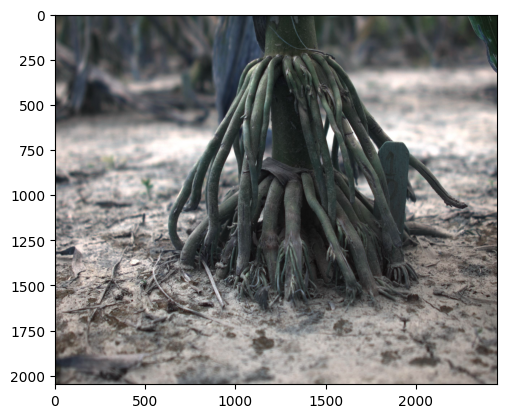

In [2]:
mutant_zmays_img = cv2.imread('./braceroot_plantcv/288.jpg')
mutant_zmays_img = np.rot90(mutant_zmays_img, k=-2)
mutant_zmays_img = pcv.white_balance(mutant_zmays_img, mode='hist', roi=None)
mutant_grays_img = cv2.cvtColor(mutant_zmays_img, cv2.COLOR_RGB2GRAY)
# mutant_grays_img = mutant_zmays_img[:,:,2]
plt.imshow(mutant_zmays_img,cmap=None)

Step 1: Apply sobel vertical edge operator on the input image

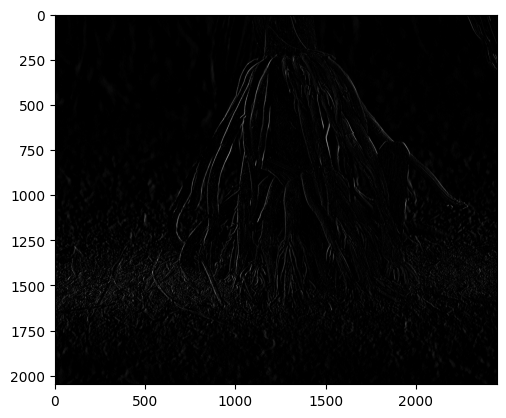

In [3]:
#Still partial to the improved one taught to me in ECE 
sobel_kernel = np.array([[-3,0,3],
                         [-10,0,10],
                         [-3,0,3]])/32
sobel_vert = cv2.filter2D(mutant_grays_img, -1, sobel_kernel)
plt.imshow(sobel_vert,cmap="Greys_r")

Step 2: Apply sobel horizontal edge operator on the image obtained from step 1.

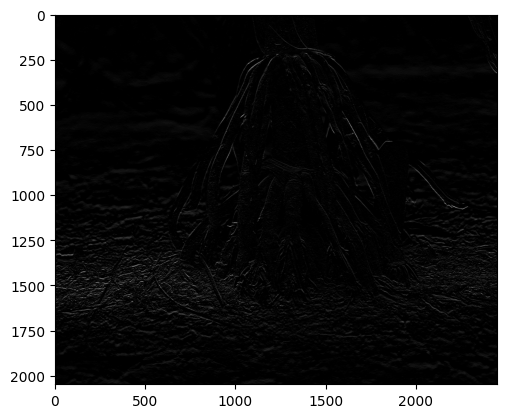

In [4]:
sobel_horiz = cv2.filter2D(mutant_grays_img, -1, sobel_kernel.T)
plt.imshow(sobel_horiz,cmap="Greys_r")

Step 3: Use Masking and add the horizontal and vertical edges to obtain the thick edges of the edge detected image obtained from step 2.

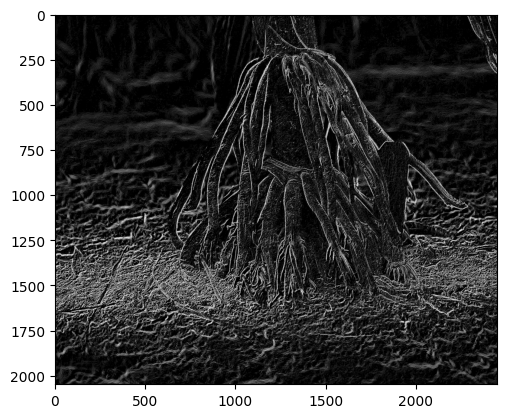

In [5]:
gradient = np.sqrt(np.square(sobel_vert) + np.square(sobel_horiz))
plt.imshow(gradient,cmap="Greys_r")

Step 4: Apply Gaussian Smoothing filter to remove noise.

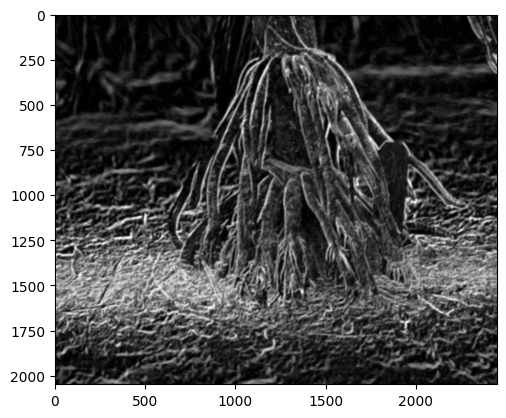

In [6]:
filtered_by_gauss = cv2.GaussianBlur(gradient.astype(np.float32),(25,25),0)
plt.imshow(filtered_by_gauss,cmap="Greys_r")

Step 5: The boundary extracted image is one or more pixel thick image. So apply the following masks to get one pixel thick image and using Hit- miss transform to get one pixel thick image.

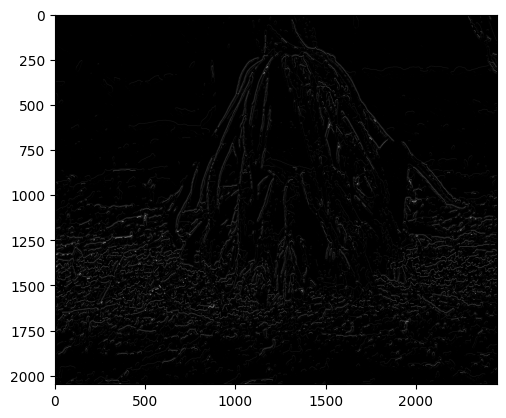

In [7]:
mask1 =  np.array([[1,1,1],
                   [0,1,1],
                   [0,-1,1]])
mask2 =  np.array([[1,1,1],
                   [1,1,0],
                   [0,-1,1]])
step5 = cv2.morphologyEx(filtered_by_gauss.astype(np.uint8),cv2.MORPH_HITMISS,mask1)
# step5 = cv2.morphologyEx(step5,cv2.MORPH_HITMISS,mask2)

plt.imshow(step5,cmap="Greys_r")

Step 6:
The operation of Hit-miss transform creates breaks in the pixel boundary. So the gaps are to be filled. To thin and fill gaps the following masks are used.

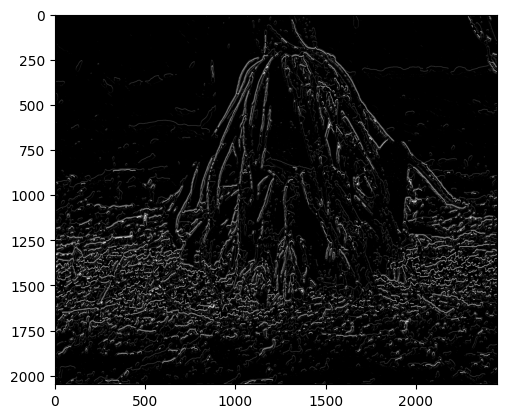

In [8]:
fill_kernel = np.array([[-1,-1,-1],
                        [-1,-1,-1],
                        [-1,-1,-1]])*-10
step6 = cv2.filter2D(step5, -1, fill_kernel)
plt.imshow(step6,cmap="Greys_r")

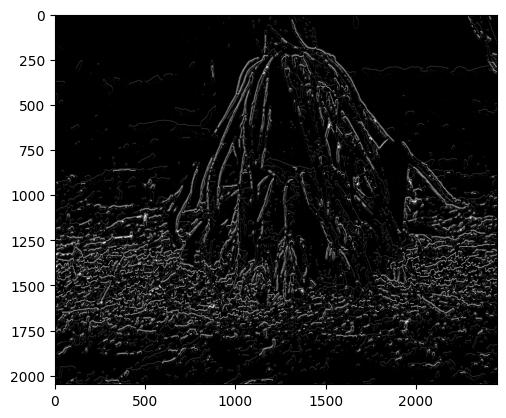

In [15]:
boundary = cv2.morphologyEx(step6, cv2.MORPH_CLOSE, fill_kernel)
plt.imshow(boundary,cmap="Greys_r")

Step 7:
To avoid the ambiguity in paths of 4-connected and 8-connected neighbors, m-connectivity is used. The mask used for this purpose is

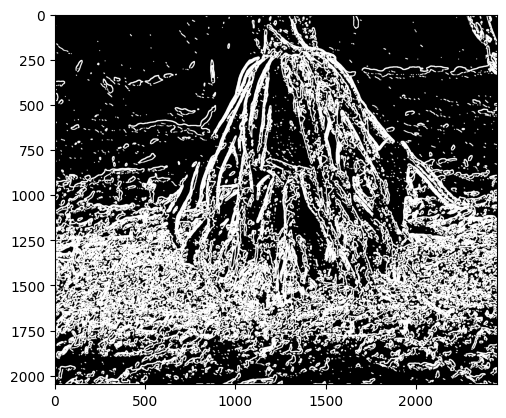

In [9]:
connectivity_kernel = np.array([[1,1,0],
                                [1,1,0],
                                [0,0,0]])
step7 = cv2.filter2D(step6, -1, fill_kernel)
plt.imshow(step7,cmap="Greys_r")

Step 8:
At the end Boundary is calculated as

Boundry = Boundry − (Boundary Ø Mask 4) where Ø is Hit-Miss transform

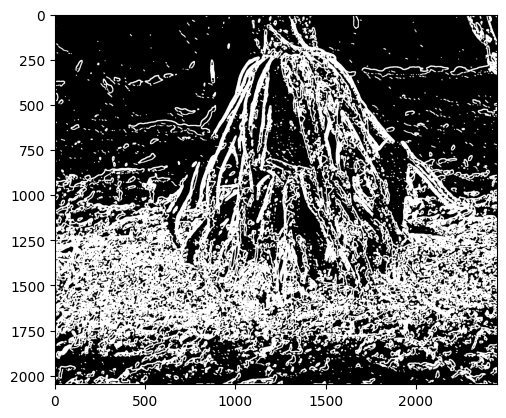

In [13]:
# boundary = step7 - cv2.morphologyEx(step7.astype(np.uint8),cv2.MORPH_HITMISS,connectivity_kernel)
boundary = cv2.morphologyEx(step7, cv2.MORPH_CLOSE, fill_kernel)
plt.imshow(boundary,cmap="Greys_r")

In [16]:
def bwareaopen(img, min_size, connectivity=8):
        """Remove small objects from binary image (approximation of 
        bwareaopen in Matlab for 2D images).
    
        Args:
            img: a binary image (dtype=uint8) to remove small objects from
            min_size: minimum size (in pixels) for an object to remain in the image
            connectivity: Pixel connectivity; either 4 (connected via edges) or 8 (connected via edges and corners).
    
        Returns:
            the binary image with small objects removed
        """
    
        # Find all connected components (called here "labels")
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            img, connectivity=connectivity)
        
        # check size of all connected components (area in pixels)
        for i in range(num_labels):
            label_size = stats[i, cv2.CC_STAT_AREA]
            
            # remove connected components smaller than min_size
            if label_size < min_size:
                img[labels == i] = 0
                
        return img

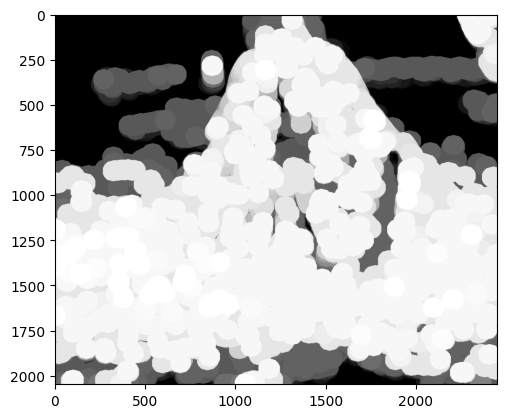

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
mikasa = boundary
mikasa = cv2.morphologyEx(mikasa, cv2.MORPH_TOPHAT, kernel)
mikasa = cv2.morphologyEx(mikasa, cv2.MORPH_GRADIENT, kernel)
mikasa = bwareaopen(mikasa, 1000)
mikasa = cv2.morphologyEx(mikasa, cv2.MORPH_CLOSE, kernel)
mikasa = bwareaopen(mikasa, 5000)
mikasa = cv2.dilate(mikasa,kernel,iterations = 7)

plt.imshow(mikasa,cmap="Greys_r")
